# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Techniques for handling missing data

</font>
</div>

# Why handling missing data is important?
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- The problem of missing data is relatively common in almost all research and can have a significant effect on the conclusions that can be drawn from the data.
Missing data present various problems. 
* First, the absence of data reduces statistical power. 
* Second, the lost data can cause bias in the estimation of parameters. 
* Third, it may complicate the analysis of the study. 
* Fourth, many machine learning packages in python does not accept missing data.

Each of these distortions may threaten the validity of the trials and can lead to invalid conclusions which reduces the reliability on the model.

</font>
</div>

# Missing data mechanisms
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- **Missing Completely At Random (MCAR):** when values in a data set are Missing Completely At Random (MCAR) if the events that lead to any particular data-item being missing are independent both of observed data and of missing data.

- **Missing At Random (MAR)** is when the missing data is related to the observed data but not the missing data.

- **Missing Not At Random (MNAR):** is when the data that is neither MAR nor MCAR. The missing values on the variable are related to that of both the observed and missing variables. 

</font>
</div>

# Options to handle missing data
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- Single Imputation attempts to impute the missing data by a single value as opposed to Multiple Imputation which replaces the missing data with multiple values.

</font>
</div>

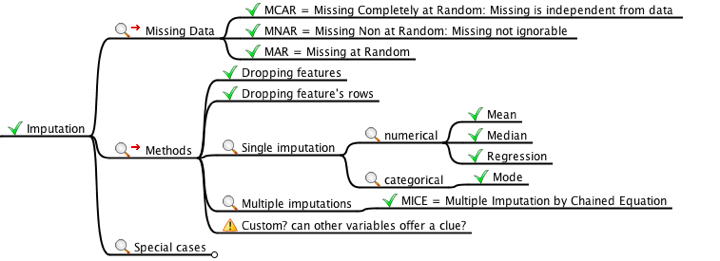

# Import mmodules
<hr style="border:2px solid black"> </hr>

In [7]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import xgboost
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns


# Load dataset
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- This is Kaggle dataset and as such there are two sets provided.
- Since the focus of this notebook is show different techniques for data imputation, we'll completely diseregard the set set.

</font>
</div>

In [3]:
train = pd.read_csv('../../DATASETS/House_Prices_Advanced_Regression_Techniques/train.csv')

# Looking for missing values
<hr style="border:2px solid black"> </hr>

In [4]:
def basic_details(df, sort_by = "Feature"):
    """Get basic details of the dataset.
    
    Missing values and their percentage
    Unique values and their percentage (Cardinality)
    Cardinality is important if you are trying to understand
    feature importance.
    Type if numerical or not    
    
    Parameters
    ----------
    df - pabdas dataframe
    sort_by - string, defaul = "Feature"
    
    Returns
    -------
    b - pandas dataframe
    """
    
    b = pd.DataFrame()
    b['No missing value'] = df.isnull().sum()
    b["Missing[%]"] = df.isna().mean()*100
    b['No unique value'] = df.nunique()
    b['Cardinality[%]'] = (df.nunique()/len(df.values))*100
    b["No Values"] = [len(df.values) for _ in range(len(df.columns))]
    b['dtype'] = df.dtypes
    
    # Some cosmetic on the table
    # Turn index into a columns
    b['Feature'] = b.index
    # Getting rid of the index
    b.reset_index(drop=True, inplace=True)
    # Order by feature name
    b.sort_values(by=[sort_by], inplace=True)
    # Move feature as first column
    b = b[['Feature'] + [col for col in b.columns if col != 'Feature']]
    
    return b

In [5]:
basic_details(train)

,Feature,No missing value,Missing[%],No unique value,Cardinality[%],No Values,dtype
43,1stFlrSF,0,0.000000,753,51.575342,1460,int64
44,2ndFlrSF,0,0.000000,417,28.561644,1460,int64
69,3SsnPorch,0,0.000000,20,1.369863,1460,int64
6,Alley,1369,93.767123,2,0.136986,1460,object
51,BedroomAbvGr,0,0.000000,8,0.547945,1460,int64
...,...,...,...,...,...,...,...
9,Utilities,0,0.000000,2,0.136986,1460,object
66,WoodDeckSF,0,0.000000,274,18.767123,1460,int64
19,YearBuilt,0,0.000000,112,7.671233,1460,int64
20,YearRemodAdd,0,0.000000,61,4.178082,1460,int64


<div class="alert alert-info">
<font color=black>

- Bird high view of which feature has a non-usable value and how many of them are there.
- As always this is done for both train and test set, for the sole purpouse of understanding if the test is representative of the training set.
- Using heatmap to show the numeric data consisting missing value in train dataset. The white bars are representing missing value.

</font>
</div>

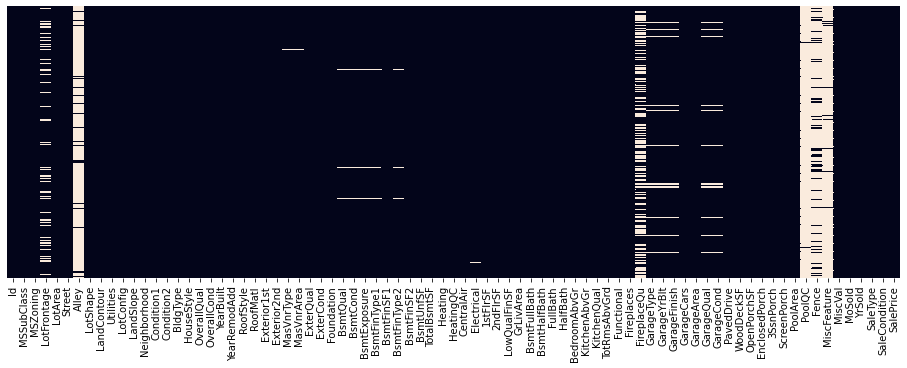

In [10]:
plt.figure(figsize=(16, 5))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False);

In [13]:
def get_cat_num_df(df):
    """Get categorical and numerical features name.
    
    Parameters
    ----------
    df - pandas dataframe
    
    Returns
    -------
    cat_cols - list
    num_cols - list
    
    """
    cat_cols = df.select_dtypes(include=['object'])
    num_cols = df.select_dtypes(exclude=['object'])
    print(
        f'The dataset contains {len(cat_cols.columns.tolist())} categorical columns')
    print(
        f'The dataset contains {len(num_cols.columns.tolist())} numeric columns')
    
    return cat_cols, num_cols

In [15]:
cat_cols_train, num_cols_train = get_cat_num_df(train)

The dataset contains 43 categorical columns
The dataset contains 38 numeric columns


In [16]:
# Missing TRAIN categorical values -> use mode (most common)
cat_cols_train_miss = cat_cols_train.columns[cat_cols_train.isnull().any()]
print(cat_cols_train_miss)

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')


In [17]:
# Missing numerical values
num_cols_train_mis = num_cols_train.columns[num_cols_train.isnull().any()]
num_cols_train_mis

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [18]:
# Missing non-numerical values
cat_cols_train_miss = cat_cols_train.columns[cat_cols_train.isnull().any()]
print(cat_cols_train_miss)

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')


In [19]:
def get_missing_values(df, threshold=20, verbose=False, sort_by = 'No missing value'):
    """Get basic details of the dataset.

    Missing values and their percentage
    Unique values and their percentage (Cardinality)
    Cardinality is important if you are trying to understand
    feature importance.
    Type if numerical or not

    Parameters
    ----------
    threshold - float [percentage]
        Used to highlihgt in yellow value that have
        a number of missing entries greater than the
        threshold
    verbose - float 
        If set to True values on console

    Returns
    -------
    df_null_values : pandas dataframe

    """

    print("\nChecking NON usable data")
    print("Threshold set at [%]", threshold)
    zero = False
    for i in df.columns:
        if df[i].isnull().sum() > 0.0:
            zero = True
            if verbose == True:
                print("%s | No missing: %.2f | Percentage %.2f" %
                  (i, df[i].isnull().sum(), df[i].isnull().mean()*100))

    if zero == False:
        print("No null values found!")

    # Pandas dataframe of the same print out shown above
    b = pd.DataFrame()
    b['No missing value'] = df.isnull().sum()
    b["Missing[%]"] = df.isna().mean()*100
    b['dtype'] = df.dtypes

    # Turn index into a columns
    b['Feature'] = b.index
    # Getting rid of the index
    b.reset_index(drop=True, inplace=True)
    # Order the entries, larger first
    
    b.sort_values(by=[sort_by], inplace=True, ascending=False)
    # Move feature as first column
    b = b[['Feature'] + [col for col in b.columns if col != 'Feature']]
    df_null_values = b

    # Highlihgt values > threshold)
    def highlight(x):
        return ['background: yellow' if v > threshold else '' for v in x]

    def bold(x):
        return ['font-weight: bold' if v > threshold else '' for v in x]

    # Visualise the highlighted df
    return df_null_values.style.apply(
        highlight, subset=["Missing[%]"]).apply(bold, subset=["Missing[%]"])

In [20]:
def plot_missing_values(df, threshold = 20):
    rcParams['font.size'] = 15
    plt.figure(figsize=(12, 10))
   
    #dummy = (df.loc[:, df.isnull().any()].isna().sum() / df.shape[0]).sort_values()
    #dummy.plot(kind='barh')
    missing = round(df.isnull().mean()*100,2)
    missing = missing[missing > 0]    
    missing.sort_values().plot(kind='barh')

    plt.axvline(x=threshold, color='r', linestyle='-', lw=4, label='Reference line')
    plt.legend()
    plt.xlabel('% of missing data', size=25)
    plt.show()

In [21]:
df_train_null_values = get_missing_values(train, threshold=20, verbose=False)


Checking NON usable data
Threshold set at [%] 20


In [22]:
df_train_null_values

,Feature,No missing value,Missing[%],dtype
72,PoolQC,1453,99.520548,object
74,MiscFeature,1406,96.301370,object
6,Alley,1369,93.767123,object
73,Fence,1179,80.753425,object
57,FireplaceQu,690,47.260274,object
3,LotFrontage,259,17.739726,float64
59,GarageYrBlt,81,5.547945,float64
64,GarageCond,81,5.547945,object
58,GarageType,81,5.547945,object
60,GarageFinish,81,5.547945,object


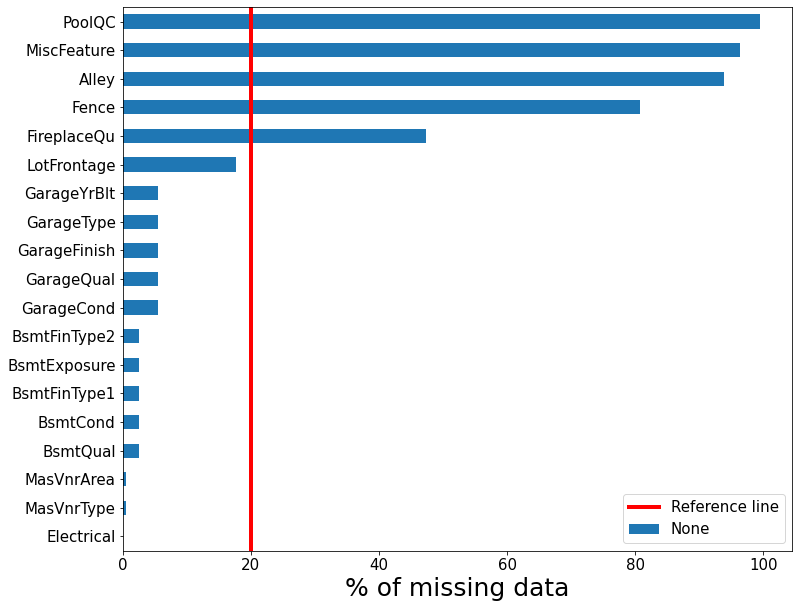

In [23]:
plot_missing_values(train)

# Option #1 - Dropping features
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- Delete the column if it consists of more than **70% of missing values** otherwise Data Imputation is the most preferred method than deleting it. 
- Greater the information to the model, the greater is the reliability of the model's results.

</font>
</div>

In [24]:
def find_missing_percent(data):
    """
    Returns dataframe containing the total missing values and percentage of total
    missing values of a column.
    """
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df = miss_df.append(dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val])),ignore_index=True)
    return miss_df

miss_df = find_missing_percent(train)
'''Columns with missing values'''
print(f"Number of columns with missing values: {str(miss_df[miss_df['PercentMissing']>0.0].shape[0])}")
display(miss_df[miss_df['PercentMissing']>0.0])

'''Drop the columns with more than 70% of missing values'''
drop_cols = miss_df[miss_df['PercentMissing'] >70.0].ColumnName.tolist()
train = train.drop(drop_cols,axis=1)

Number of columns with missing values: 19


,ColumnName,TotalMissingVals,PercentMissing
3,LotFrontage,259.0,17.74
6,Alley,1369.0,93.77
25,MasVnrType,8.0,0.55
26,MasVnrArea,8.0,0.55
30,BsmtQual,37.0,2.53
31,BsmtCond,37.0,2.53
32,BsmtExposure,38.0,2.60
33,BsmtFinType1,37.0,2.53
35,BsmtFinType2,38.0,2.60
42,Electrical,1.0,0.07


# Option #2 - Delete rows
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

**Listwise deletion** is a technique in which the rows that contain missing values are deleted.

**Disadvantages:**
Listwise deletion affects statistical power of the tests conducted. Statistical power relies in part on high sample size. Because listwise deletion excludes data with missing values, it reduces the sample which is being statistically analysed.

* Listwise deletion is also problematic when the data is **Missing Not At Random (MNAR)** (i.e., questions aiming to extract sensitive information). Many of the subjects in the sample may not answer due to the intrusive nature of the questions, but may answer all other items. 
* Listwise deletion will exclude these respondents from analysis. This may create a **bias** in the dataset.

**[Reference](https://en.wikipedia.org/wiki/Listwise_deletion)** 

</font>
</div>

In [25]:
def listwise_deletion(train):
    for col in train.columns:
        miss_ind = train[col][train[col].isnull()].index
        train = train.drop(miss_ind, axis = 0)
    return train

train_lwd = listwise_deletion(train)
'''Samples remaining after deletion'''
print(f"Train data shape:{train_lwd.shape}")
train_lwd.head()

Train data shape:(583, 77)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
6,7,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,307000


# Option #3 - Numerical feature -> use mean
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- Single Imputation for Numeric columns
- Mean Imputation is the process of imputing the missing data by the mean of the variable and can be done only to numeric columns.
- **Disadvantage:** Mean Imputation is more likely to introduce bias in the model.
- If the feature is skewed you may want to consider using the median instead. 

</font>
</div>

In [26]:
'''Segregate numeric and categoric columns'''
numeric_cols = train.select_dtypes(['float','int']).columns
categoric_cols = train.select_dtypes('object').columns

train_numeric = train[numeric_cols]
train_categoric = train[categoric_cols]

def mean_imputation(train_numeric):
    """
    Mean Imputation
    """
    for col in train_numeric.columns:
        mean = train_numeric[col].mean()
        train_numeric[col] = train_numeric[col].fillna(mean)
    return train_numeric

train_mean_imp = mean_imputation(train_numeric)
train_mean_imp.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


# Option #4 - Numerical feature -> use regression
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- A Regression model is fitted where the predictors are the features without missing values and the targets are the features with missing values. 
- The missing values are then replaced with the predictions. 
- Regression imputation is less likely to introduce bias in the model.

</font>
</div>

In [27]:
'''Select all the numeric columns for regression imputation'''
train_numeric_regr = train[numeric_cols]
'''Numeric columns with missing values which acts as target in training'''
target_cols = ['LotFrontage','GarageYrBlt']
'''Predictors for regression imputation'''
predictors = train_numeric_regr.drop(target_cols, axis =1)

def find_missing_index(train_numeric_regr, target_cols):
    """
    Returns the index of the missing values in the columns.
    """
    miss_index_dict = {}
    for tcol in target_cols:
        index = train_numeric_regr[tcol][train_numeric_regr[tcol].isnull()].index
        miss_index_dict[tcol] = index
    return miss_index_dict

def regression_imputation(train_numeric_regr, target_cols, miss_index_dict):
    """
    Fits XGBoost Regressor and replaces the missing values with
    the prediction.
    """
    for tcol in target_cols:
        y = train_numeric_regr[tcol]
        '''Initially impute the column with mean'''
        y = y.fillna(y.mean())
        xgb = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
        '''Fit the model where y is the target column which is to be imputed'''
        xgb.fit(predictors, y)
        predictions = pd.Series(xgb.predict(predictors),index= y.index)    
        index = miss_index_dict[tcol]
        '''Replace the missing values with the predictions'''
        train_numeric_regr[tcol].loc[index] = predictions.loc[index]
    return train_numeric_regr

miss_index_dict = find_missing_index(train_numeric_regr, target_cols)
train_numeric_regr = regression_imputation(train_numeric_regr, target_cols, miss_index_dict)
train_numeric_regr.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


# Option #5 - Categorical feature -> use mode
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- Mode Imputation is the process of imputing the missing data by the mode of the variable and can be done only to categoric columns.
- **Disadvantage:** More likely to introduce bias in the model. 

</font>
</div>

In [28]:
def mode_imputation(train_categoric):
    """
    Mode Imputation
    """
    for col in train_categoric.columns:
        mode = train_categoric[col].mode().iloc[0]
        train_categoric[col] = train_categoric[col].fillna(mode)
    return train_categoric

train_mode_imp = mode_imputation(train_categoric)
'''Concatenate the mean and mode imputed columns'''
train_imputed = pd.concat([train_mean_imp, train_mode_imp], axis = 1)
train_imputed.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


# Option #6 - MICE
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- MICE (Multiple Imputation by Chained Equation) meaning the missing data is imputed with multiple values.

- **MICE algorithm for numerical data**
    - **Step 1:** A simple imputation, such as imputing the mean, is performed for every missing value in the dataset. These mean imputations can be thought of as “place holders.”
    - **Step 2:** The “place holder” mean imputations for one variable (“var”) are set back to missing.
    - **Step 3:** The observed values from the variable “var” in Step 2 are regressed(can use any other regressors like Gradient Boosting Regressor or XGBoost Regressor for numeric data) on the other variables in the imputation model, which may or may not consist of all of the variables in the dataset. In other words, “var” is the dependent variable in a regression model and all the other variables are independent variables in the regression model. These regression models operate under the same assumptions that one would make when performing linear, logistic, or Poison regression models outside of the context of imputing missing data.
    - **Step 4:** The missing values for “var” are then replaced with predictions (imputations) from the regression model. When “var” is subsequently used as an independent variable in the regression models for other variables, both the observed and these imputed values will be used.
    - **Step 5:** Steps 2–4 are then repeated for each variable that has missing data. The cycling through each of the variables constitutes one iteration or “cycle.” At the end of one cycle all of the missing values have been replaced with predictions from regressions that reflect the relationships observed in the data.
    - **Step 6:** Steps 2–4 are repeated for a number of cycles, with the imputations being updated at each cycle.

        
- **MICE algorithm for categorical data**: before going through the steps 1 to 6 in MICE algorithm the following steps must be done in order to impute categorical data.
    - **Step 1:** Ordinal Encode the non-null values
    - **Step 2:** Use MICE imputation with Gradient Boosting Classifier to impute the ordinal encoded data
    - **Step 3:** Convert back from ordinal values to categorical values.
    - **Step 4:** Follow steps 1 to 6 in MICE Algorithm. Instead of using Mean imputation for initial strategy use **Mode imputation**.

</font>
</div>

In [30]:
def mice_imputation_numeric(train_numeric):
    """
    Impute numeric data using MICE imputation with Gradient Boosting Regressor.
    (we can use any other regressors to impute the data)
    """
    iter_imp_numeric = IterativeImputer(GradientBoostingRegressor())
    imputed_train = iter_imp_numeric.fit_transform(train_numeric)
    train_numeric_imp = pd.DataFrame(imputed_train, columns = train_numeric.columns, index= train_numeric.index)
    return train_numeric_imp

def mice_imputation_categoric(train_categoric):
    """
    Impute categoric data using MICE imputation with Gradient Boosting Classifier.
    Steps:
    1. Ordinal Encode the non-null values
    2. Use MICE imputation with Gradient Boosting Classifier to impute the ordinal encoded data
    (we can use any other classifier to impute the data)
    3. Inverse transform the ordinal encoded data.
    """
    ordinal_dict={}
    for col in train_categoric:
        '''Ordinal encode train data'''
        ordinal_dict[col] = OrdinalEncoder()
        nn_vals = np.array(train_categoric[col][train_categoric[col].notnull()]).reshape(-1,1)
        nn_vals_arr = np.array(ordinal_dict[col].fit_transform(nn_vals)).reshape(-1,)
        train_categoric[col].loc[train_categoric[col].notnull()] = nn_vals_arr

    '''Impute the data using MICE with Gradient Boosting Classifier'''
    iter_imp_categoric = IterativeImputer(GradientBoostingClassifier(), max_iter =5, initial_strategy='most_frequent')
    imputed_train = iter_imp_categoric.fit_transform(train_categoric)
    train_categoric_imp = pd.DataFrame(imputed_train, columns =train_categoric.columns,index = train_categoric.index).astype(int)
    
    '''Inverse Transform'''
    for col in train_categoric_imp.columns:
        oe = ordinal_dict[col]
        train_arr= np.array(train_categoric_imp[col]).reshape(-1,1)
        train_categoric_imp[col] = oe.inverse_transform(train_arr)
        
    return train_categoric_imp

train_numeric_imp  = mice_imputation_numeric(train_numeric)
train_categoric_imp = mice_imputation_categoric(train_categoric)

'''Concatenate Numeric and Categoric Training and Test set data '''
train_mice_imp = pd.concat([train_numeric_imp, train_categoric_imp, train['SalePrice']], axis = 1)
train_mice_imp.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal,208500
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,181500
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,223500
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,250000


# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- [Kaggle dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
- [This python notebook codes](https://www.kaggle.com/srivignesh/techniques-for-handling-the-missing-data)
- [Missing data mechanism #1](https://en.wikipedia.org/wiki/Missing_data#Missing_not_at_random)
- [Missing data mechanism #2](https://www.slideshare.net/GaelVaroquaux/dirty-data-science-machine-learning-on-noncurated-data)
- [Importance of missing data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/)
- [MICE #1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)   
- [MICE #2](https://projector-video-pdf-converter.datacamp.com/17404/chapter4.pdf)

</font>
</div>